# "Two-stage" regression to incorporate predictors into lowess

## Overview

Adding an indicator for zero-fh-tbes: this is a general way of handling "outliers".<br>
We tell the model to treat these differently, and not force the overall time trend<br>
to absorb the effect of these outliers. This way, we sidestep the conversation of<br>
"Do we include outliers or not?", and use modeling to "automate away" the decision.<br>
<br>
A long time ago, we achieved something similar by using a single KM curve to unify<br>
censored and uncensored data points, instead of asking the user to select which of<br>
them to plot Similarly, by building a model that includes predictors of interest<br>
(tail_id, CMD, etc.), we are starting to "automate away" the process that happens<br>
after a univariate alert is thrown. Ideally, we should not need to follow up an<br>
alert with a lot of manual investigation - estimating the model gives us the<br>
results, with the additional benefit of considering interactions.

todo:<br>
 - rename file<br>
 - clean up overview<br>
 - ~add interaction between x1 and x2~<br>
 - ~show that slope of x1 in model m4 is equal to slope of x1 in model:~<br>
     ~resid(y~x2+x3) ~ resid(x1~x2+x3)~<br>
 - ~show graph of resid(y~x2+x3) vs resid(x1~x2+x3)~<br>
 - try to fit lowess on resid(y~x2+x3) vs resid(x1~x2+x3). Think of these as<br>
     y_adjusted and x1_adjusted

## References:

- [statsmodels docs on lowess](https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html)  # noqa<br>
- [sklearn source for shuffling and splitting a dataset](https://github.com/scikit-learn/scikit-learn/blob/dc580a8ef5ee2a8aea80498388690e2213118efd/sklearn/model_selection/_split.py#L1721)  # noqa<br>
- [CV: how are partial regression slopes calculated in multiple regression?](https://stats.stackexchange.com/questions/77557/how-are-partial-regression-slopes-calculated-in-multiple-regression)  # noqa<br>
  - also see Agresti, p60.<br>
- [statsmodels github issue on lowess failing when too few unique values](https://github.com/statsmodels/statsmodels/issues/2449)  # noqa

In [2]:
import math
from dataclasses import dataclass

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [4]:
@dataclass
class SimParams:
    num_rows: int = 100
    prop_zero_y: float = 0.65
    b_0: float = 50
    b_1: float = 0.4
    sigma: float = 10
    num_zero_y: float = math.ceil(prop_zero_y * num_rows)
    equality_thresh: float = 0.001

In [5]:
@dataclass
class ModelingParams:
    lowess_frac: float = 0.2

In [6]:
p = SimParams()
m = ModelingParams()

## Data setup

In [7]:
np.random.seed(2022)
x1 = np.random.uniform(low=0, high=100, size=p.num_rows)

Set up y

In [8]:
y_no_noise_and_no_zero_values = p.b_0 + p.b_1 * x1
y_no_zero_values = y_no_noise_and_no_zero_values + np.random.normal(
    scale=p.sigma, size=p.num_rows
)
y = np.copy(y_no_zero_values)
idx_for_zero_y = np.random.permutation(np.arange(len(x1)))[: p.num_zero_y]
y[idx_for_zero_y] = 0

Set up full X matrix, including indicator for zero_y outlier events, and interaction<br>
between x1 and x2:

In [9]:
x2 = np.zeros(p.num_rows)
x2[idx_for_zero_y] = 1
x3 = x1 * x2

In [10]:
X = np.stack((x1, x2, x3), axis=1)
assert X.shape == (100, 3)

Putting it all in a df for display:

In [11]:
df_X = pd.DataFrame(X)
df_X.columns = ["x1", "x2", "x3"]
df_X.head(10)

,x1,x2,x3
0,0.935861,1.0,0.935861
1,49.905781,1.0,49.905781
2,11.338369,0.0,0.000000
3,4.997402,0.0,0.000000
4,68.540759,1.0,68.540759
5,48.698807,0.0,0.000000
6,89.765723,0.0,0.000000
7,64.745207,1.0,64.745207
8,89.696312,1.0,89.696312
9,72.113493,1.0,72.113493


Plots showing how we built up the data

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\284710517.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


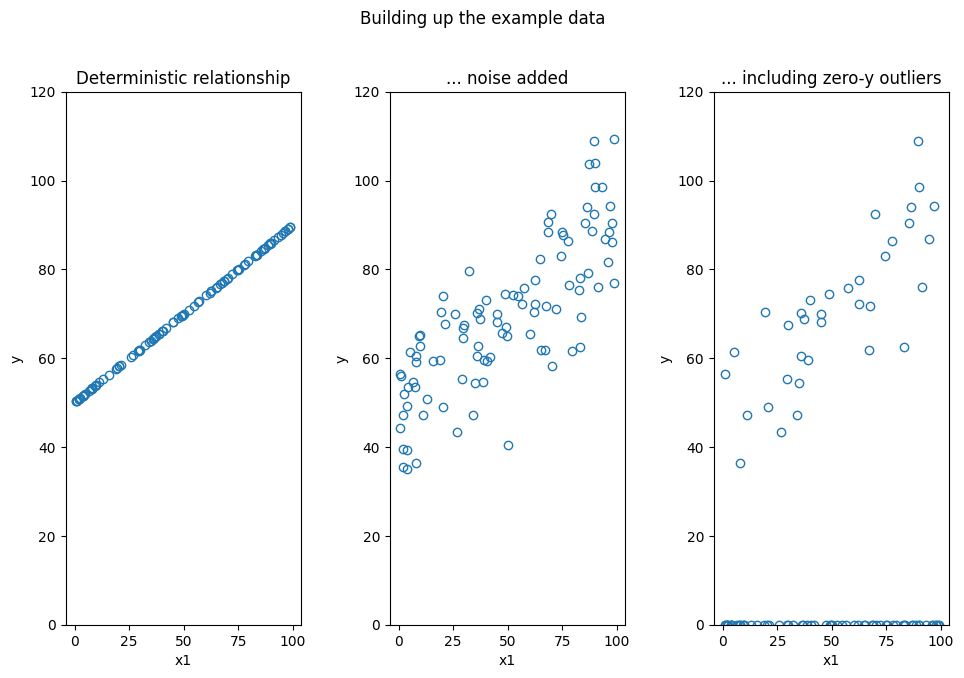

In [12]:
title = "Building up the example data"
subtitles = [
    "Deterministic relationship",
    "... noise added",
    "... including zero-y outliers",
]
fig = plt.figure(figsize=(10, 7))
for idx, y in enumerate([y_no_noise_and_no_zero_values, y_no_zero_values, y]):
    ax = plt.subplot(1, 3, idx + 1)
    ax.plot(x1, y, "o", mfc="none")
    ax.set_ylim(0, 120)
    ax.set_title(subtitles[idx])
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
fig.suptitle(title)
fig.tight_layout(pad=2)
fig.show()

## Single-stage lowess for y~x1

In [13]:
lowess = sm.nonparametric.lowess
y_lowess = lowess(y, x1, frac=m.lowess_frac)
assert y_lowess.shape == (100, 2)

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\161097604.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


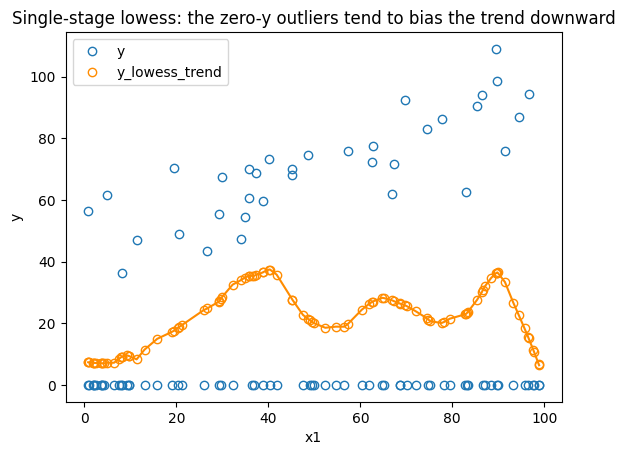

In [14]:
title = "Single-stage lowess: the zero-y outliers tend to bias the trend downward"
fig, ax = plt.subplots()
ax.plot(x1, y, "o", mfc="none", label="y")
ax.plot(
    y_lowess[:, 0],
    y_lowess[:, 1],
    "o",
    mfc="none",
    label="y_lowess_trend",
    color="darkorange",
)
ax.plot(y_lowess[:, 0], y_lowess[:, 1], color="darkorange")
ax.set_title(title)
ax.set_xlabel("x1")
ax.set_ylabel("y")
ax.legend()
fig.show()

## "Two-stage" Lowess

### First stage model 1: y~x2 (x2 is categorical indicator for outliers).

The residuals from this model give us "the part of y that is not explained by x2".

In [15]:
X_categorical = X[:, 1].reshape(-1, 1)

In [16]:
lm_y_x2 = LinearRegression(fit_intercept=True)
lm_y_x2.fit(X_categorical, y)

LinearRegression()

In [17]:
(
    lm_y_x2.intercept_,
    lm_y_x2.coef_,
    lm_y_x2.score(X_categorical, y),
    cross_val_score(lm_y_x2, X_categorical, y, cv=5, scoring="r2").mean(),
)

(70.45593044532859,
 array([-70.45593045]),
 0.9211057327270966,
 0.9093527950315817)

Time series cv might be more appropriate when trends are expected

In [18]:
tscv_r2 = []
tscv = TimeSeriesSplit(n_splits=5)
for train, test in tscv.split(X_categorical):
    m = LinearRegression(fit_intercept=True)
    m.fit(X_categorical[train], y[train])
    r2 = m.score(X_categorical[test], y[test])
    tscv_r2.append(r2)
np.array(tscv_r2).mean()

0.9188237073969006

In [19]:
predictions_lm_y_x2 = lm_y_x2.predict(X_categorical)
residuals_lm_y_x2 = y - predictions_lm_y_x2

Notice how much variability in y is explained by categorical x2:

In [20]:
print(
    f"Prop of variation in y explained by categorical x2: "
    f"{round(lm_y_x2.score(X_categorical, y), 3)}"
)

Prop of variation in y explained by categorical x2: 0.921


### First stage model 2: x1 ~ x2

The residuals from this model give us "the part of x1 that is not explained by x2".

In [21]:
df_means = df_X.groupby("x2").mean().reset_index().rename(columns={"x1": "mean_x1"})
means_x1 = df_means["mean_x1"].to_numpy()

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\4277746908.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


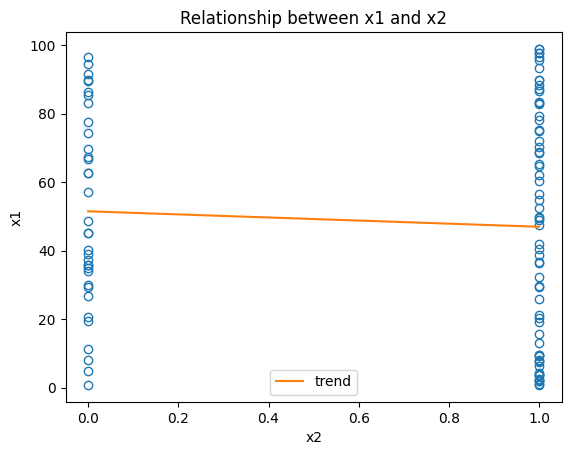

In [22]:
title = "Relationship between x1 and x2"
fig, ax = plt.subplots()
ax.plot(x2, x1, "o", mfc="none")
ax.plot(df_means["x2"].unique(), means_x1, label="trend")
ax.set_title(title)
ax.set_xlabel("x2")
ax.set_ylabel("x1")
ax.legend()
fig.show()

In [23]:
lm_x1_x2 = LinearRegression(fit_intercept=True)
lm_x1_x2.fit(X_categorical, x1)

LinearRegression()

In [24]:
(
    lm_x1_x2.intercept_,
    lm_x1_x2.coef_,
    lm_x1_x2.score(X_categorical, x1),
    cross_val_score(lm_x1_x2, X_categorical, x1, scoring="r2").mean(),
)

(51.48545205278295,
 array([-4.51008535]),
 0.0045839801445047845,
 -0.10363665537567454)

Time series cv might be more appropriate when trends are expected

In [25]:
tscv_r2 = []
tscv = TimeSeriesSplit(n_splits=5)
for train, test in tscv.split(X_categorical):
    m = LinearRegression(fit_intercept=True)
    m.fit(X_categorical[train], x1[train])
    r2 = m.score(X_categorical[test], x1[test])
    tscv_r2.append(r2)
np.array(tscv_r2).mean()

-0.11511758605193098

In [26]:
predictions_lm_x1_x2 = lm_x1_x2.predict(X_categorical)
residuals_lm_x1_x2 = x1 - predictions_lm_x1_x2

Putting it all in a df for display:

In [27]:
df_with_resids = pd.concat(
    [
        df_X,
        pd.Series(y),
        pd.Series(predictions_lm_y_x2),
        pd.Series(residuals_lm_y_x2),
        pd.Series(predictions_lm_x1_x2),
        pd.Series(residuals_lm_x1_x2),
    ],
    axis=1,
)
df_with_resids.columns = df_X.columns.tolist() + [
    "y",
    "predictions_lm_y_x2",
    "residuals_lm_y_x2",
    "predictions_lm_x1_x2",
    "residuals_lm_x1_x2",
]
df_with_resids.head(5)

,x1,x2,x3,y,predictions_lm_y_x2,residuals_lm_y_x2,predictions_lm_x1_x2,residuals_lm_x1_x2
0,0.935861,1.0,0.935861,0.000000,-1.421085e-14,1.421085e-14,46.975367,-46.039505
1,49.905781,1.0,49.905781,0.000000,-1.421085e-14,1.421085e-14,46.975367,2.930414
2,11.338369,0.0,0.000000,47.130592,7.045593e+01,-2.332534e+01,51.485452,-40.147083
3,4.997402,0.0,0.000000,61.444763,7.045593e+01,-9.011168e+00,51.485452,-46.488050
4,68.540759,1.0,68.540759,0.000000,-1.421085e-14,1.421085e-14,46.975367,21.565393


Plot the residuals from the two first-stage models, versus predictor x1:

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\3279477296.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


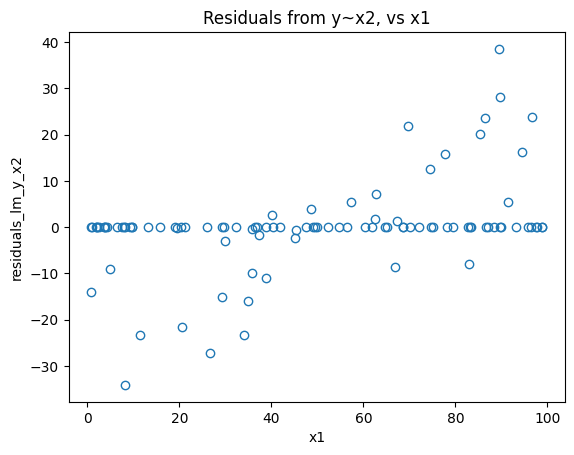

In [28]:
title = "Residuals from y~x2, vs x1"
fig, ax = plt.subplots()
ax.plot(x1, residuals_lm_y_x2, "o", mfc="none")
ax.set_title(title)
ax.set_xlabel("x1")
ax.set_ylabel("residuals_lm_y_x2")
fig.show()

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\2828905470.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


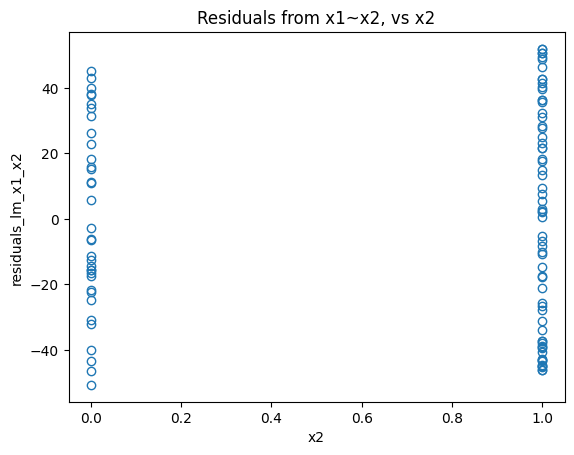

In [29]:
title = "Residuals from x1~x2, vs x2"
fig, ax = plt.subplots()
ax.plot(x2, residuals_lm_x1_x2, "o", mfc="none")
ax.set_title(title)
ax.set_xlabel("x2")
ax.set_ylabel("residuals_lm_x1_x2")
fig.show()

## Partial regression plot: residuals_lm_y_x2 vs residuals_lm_x1_x2

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\1739327989.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


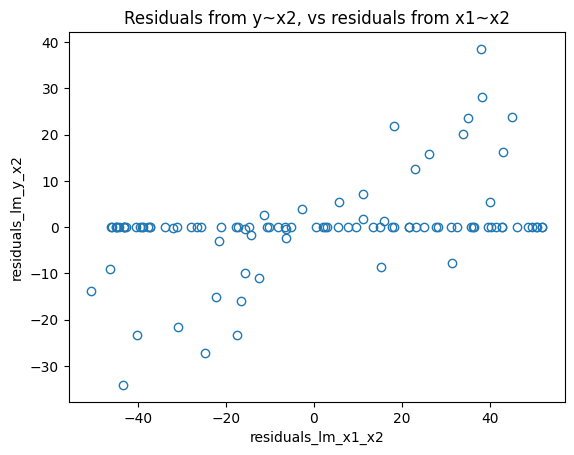

In [30]:
title = "Residuals from y~x2, vs residuals from x1~x2"
fig, ax = plt.subplots()
ax.plot(residuals_lm_x1_x2, residuals_lm_y_x2, "o", mfc="none")
ax.set_title(title)
ax.set_xlabel("residuals_lm_x1_x2")
ax.set_ylabel("residuals_lm_y_x2")
fig.show()

## Lowess on residuals, focusing on non-outlier points

residuals_lm_x1_x2_jittered = (<br>
    residuals_lm_x1_x2 + np.random.normal(scale=100, size=p.num_rows)<br>
)<br>
residuals_lm_y_x2_jittered = (<br>
    residuals_lm_y_x2 + np.random.normal(scale=100, size=p.num_rows)<br>
)

resid_lowess = lowess(<br>
    residuals_lm_x1_x2_jittered, residuals_lm_y_x2, frac=m.lowess_frac<br>
)<br>
assert resid_lowess.shape == (p.num_rows, 2)

todo: explain these

regress resid(y ~ x2) ~ resid(x1 ~ x2)

In [31]:
m = LinearRegression().fit(residuals_lm_x1_x2.reshape(-1, 1), residuals_lm_y_x2)
y2 = m.predict(residuals_lm_x1_x2.reshape(-1, 1))
m.coef_

array([0.1310092])

regress y ~ x1 + x2

In [32]:
m2 = LinearRegression().fit(X[:, :2], y)
m2.coef_

array([  0.1310092 , -69.86506778])

regress y ~ x1

In [33]:
m3 = LinearRegression().fit(X[:, 0].reshape(-1, 1), y)
m3.coef_

array([0.20201896])

This shows that slope of the line in resid(y ~ x2) vs resid(x1 ~ x2) is equal to the<br>
coefficient of x1 in y ~ x1 + x2

In [34]:
assert m.coef_.tolist()[0] - m2.coef_[0] < p.equality_thresh

regress y ~ x1 + x2 + x3

In [35]:
m4 = LinearRegression().fit(X, y)
predict_m4 = m4.predict(X)
m4.coef_, m4.intercept_

(array([  0.47873704, -45.80793729,  -0.47873704]), 45.807937287772006)

get resid(y ~ x2 + x3)

In [36]:
m4_0 = LinearRegression().fit(X[:, 1:], y)
predictions_m4_0 = m4_0.predict(X[:, 1:])
residuals_m4_0 = y - predictions_m4_0

get resid(x1 ~ x2 + x3)

In [37]:
m4_1 = LinearRegression().fit(X[:, 1:], X[:, 0])
predictions_m4_1 = m4_1.predict(X[:, 1:])
residuals_m4_1 = X[:, 0] - predictions_m4_1

regress resid(y ~ x2 + x3) vs resid(x1 ~ x2 + x3)

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\4192890615.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


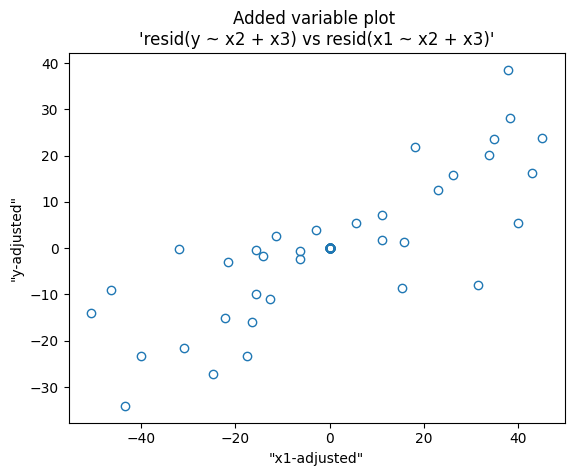

In [38]:
title = "Added variable plot \n'resid(y ~ x2 + x3) vs resid(x1 ~ x2 + x3)'"
fig, ax = plt.subplots()
ax.plot(residuals_m4_1, residuals_m4_0, "o", mfc="none", label="series_01")
ax.set_title(title)
ax.set_xlabel('"x1-adjusted"')
ax.set_ylabel('"y-adjusted"')
fig.show()

In [39]:
m4_3 = LinearRegression().fit(residuals_m4_1.reshape(-1, 1), residuals_m4_0)
m4_3.coef_

array([0.47873704])

In [40]:
assert m4.coef_.tolist()[0] - m4_3.coef_ < p.equality_thresh

In [41]:
m4.score(X, y)
cross_val_score(m4, X, y, cv=5, scoring="r2").mean()

0.9621372028521991

Time series cv might be more appropriate when trends are expected

In [42]:
tscv_r2 = []
tscv = TimeSeriesSplit(n_splits=5)
for train, test in tscv.split(X):
    m = LinearRegression(fit_intercept=True)
    m.fit(X[train], y[train])
    r2 = m.score(X[test], y[test])
    tscv_r2.append(r2)
np.array(tscv_r2).mean()

0.9630172453010978

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\3130430187.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


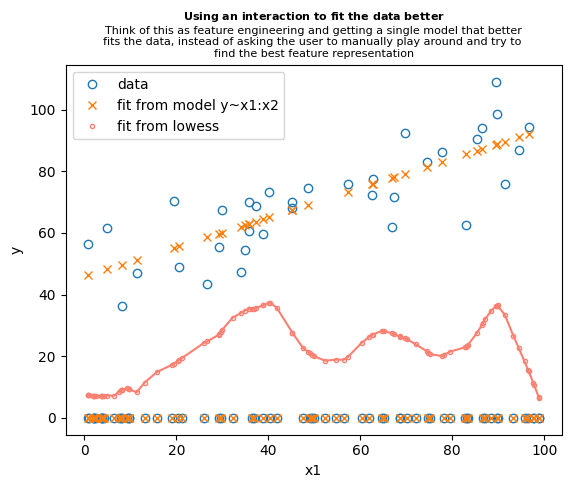

In [43]:
title = r"$\bf{Using \ an \ interaction \ to \ fit \ the \ data \ better}$"
title += "\nThink of this as feature engineering and getting a single model that better"
title += (
    "\nfits the data, instead of asking the user to manually play around and try to "
)
title += "\nfind the best feature representation"
fig, ax = plt.subplots()
ax.plot(x1, y, "o", mfc="none", label="data")
ax.plot(x1, predict_m4, "x", mfc="none", label="fit from model y~x1:x2")
ax.plot(
    y_lowess[:, 0],
    y_lowess[:, 1],
    ".",
    mfc="none",
    label="fit from lowess",
    color="salmon",
)
ax.plot(
    y_lowess[:, 0],
    y_lowess[:, 1],
    color="salmon",
)
ax.set_title(title)
ax.title.set_size(8)
ax.set_xlabel("x1")
ax.set_ylabel("y")
ax.legend()
fig.show()

todo: update this. show that slope of x1 in model m4 is equal to slope of x1 in<br>
  model: resid(y~x2+x3) ~ resid(x1~x2+x3)

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\3656267696.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


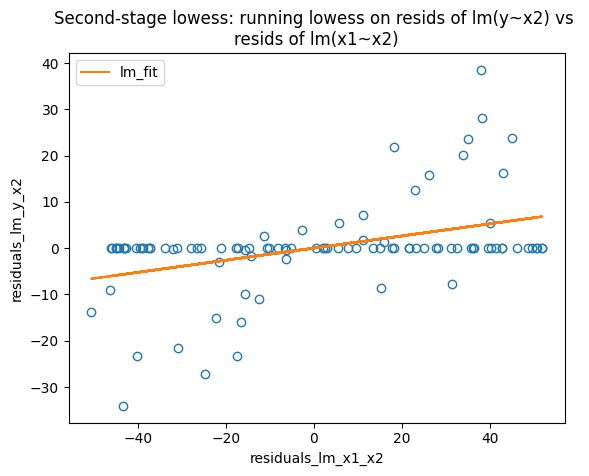

In [44]:
title = "Second-stage lowess: running lowess on resids of lm(y~x2) vs "
title += "\nresids of lm(x1~x2)"
fig, ax = plt.subplots()
ax.plot(residuals_lm_x1_x2, residuals_lm_y_x2, "o", mfc="none", label="")
ax.plot(residuals_lm_x1_x2, y2, label="lm_fit")
ax.set_title(title)
ax.set_xlabel("residuals_lm_x1_x2")
ax.set_ylabel("residuals_lm_y_x2")
ax.legend()
fig.show()

C:\Users\vr229e\AppData\Local\Temp\ipykernel_34116\1319092451.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


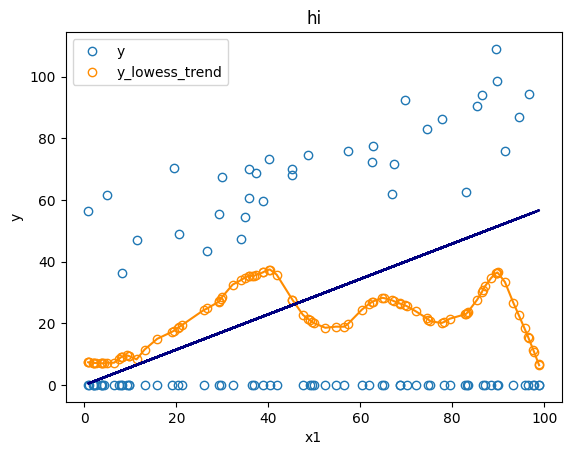

In [45]:
title = "hi"  # todo:
fig, ax = plt.subplots()
ax.plot(x1, y, "o", mfc="none", label="y")
ax.plot(
    y_lowess[:, 0],
    y_lowess[:, 1],
    "o",
    mfc="none",
    label="y_lowess_trend",
    color="darkorange",
)
ax.plot(y_lowess[:, 0], y_lowess[:, 1], color="darkorange")
ax.plot(x1, m.coef_[0] * x1, color="navy")  # todo: fix this
ax.set_title(title)
ax.set_xlabel("x1")
ax.set_ylabel("y")
ax.legend()
fig.show()